In [331]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [332]:
# Specify time window
days_in_past = 1
time_window = f'{days_in_past}' + 'D'

In [333]:
# Specify the data file here
df = pd.read_csv("./dataset_mood_smartphone.csv")

In [334]:
# Removing the Unnamed column from the dataframe
df.drop(columns="Unnamed: 0", inplace=True)

In [335]:
# Converting features to date and time
df["time"] = pd.to_datetime(df['time'])
df["date"] = pd.to_datetime(df['time'].dt.date)

In [336]:
# Processing Quantiles
variables_list = df['variable'].unique()

for var in variables_list:
    # Select the variable
    screen_values = df[df['variable'] == var]['value']

    # Calculate Q1, Q3, and IQR
    Q1 = screen_values.quantile(0.05)
    Q3 = screen_values.quantile(0.95)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR

    # Filter out outliers
    filtered_screen_values = screen_values[(screen_values >= lower_bound) & (screen_values <= upper_bound)]

    # Directly filtering df
    df = df[(df['variable'] != var) | ((df['variable'] == var) & (df['value'] >= lower_bound) & (df['value'] <= upper_bound))]


In [337]:
# Pivot the DataFrame based on id and date and average values on a day level
df_pivoted = df.pivot_table(index=['id', 'date'], columns='variable', values='value', aggfunc=['mean', 'count', 'sum']).reset_index()

# Renaming columns to remove multi-level index
df_pivoted.columns = [f"{var}{agg}" for var, agg in df_pivoted.columns]
df_pivoted

,id,date,meanactivity,meanappCat.builtin,meanappCat.communication,meanappCat.entertainment,meanappCat.finance,meanappCat.game,meanappCat.office,meanappCat.other,...,sumappCat.travel,sumappCat.unknown,sumappCat.utilities,sumappCat.weather,sumcall,sumcircumplex.arousal,sumcircumplex.valence,summood,sumscreen,sumsms
0,AS14.01,2014-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
1,AS14.01,2014-02-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,AS14.01,2014-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,2.0
3,AS14.01,2014-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,3.0
4,AS14.01,2014-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,AS14.33,2014-05-27,0.012704,5.004143,59.382943,62.347000,NaN,NaN,NaN,17.835750,...,NaN,NaN,56.173,NaN,1.0,-3.0,2.0,31.0,4089.879001,2.0
1969,AS14.33,2014-05-28,0.103301,7.718042,37.238750,43.907571,NaN,NaN,21.254,27.891895,...,NaN,NaN,30.666,NaN,10.0,0.0,6.0,41.0,7551.971998,1.0
1970,AS14.33,2014-05-29,0.169354,6.452161,54.388125,68.369000,NaN,NaN,NaN,9.734000,...,0.939,NaN,3.199,NaN,5.0,-4.0,3.0,21.0,560.093000,1.0
1971,AS14.33,2014-05-30,0.192901,11.251162,46.412278,37.174286,NaN,NaN,NaN,10.522000,...,1052.648,8.072,232.825,NaN,4.0,-4.0,-2.0,34.0,8649.867999,NaN


In [338]:
# This are the features now on a daily level
features = df_pivoted.columns.to_list()
features.remove('id')
features.remove('date')
print(len(features))

57


In [339]:
### Creating Target  and target date columns ###

# Sort data by ID and date to ensure proper alignment
df_pivoted.sort_values(by=['id', 'date'], inplace=True)

# Create a new column by shifting the 'feature' column by -1 within each 'id' group
df_pivoted['Target'] = df_pivoted.groupby('id')['meanmood'].shift(-1)

# Similarly, shift the 'date' column to see the date of the target feature
df_pivoted['Target_date'] = df_pivoted.groupby('id')['date'].shift(-1)

In [340]:
# Displaying dataframe
df_pivoted

,id,date,meanactivity,meanappCat.builtin,meanappCat.communication,meanappCat.entertainment,meanappCat.finance,meanappCat.game,meanappCat.office,meanappCat.other,...,sumappCat.utilities,sumappCat.weather,sumcall,sumcircumplex.arousal,sumcircumplex.valence,summood,sumscreen,sumsms,Target,Target_date
0,AS14.01,2014-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-18
1,AS14.01,2014-02-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-19
2,AS14.01,2014-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.0,NaN,NaN,NaN,NaN,2.0,NaN,2014-02-20
3,AS14.01,2014-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,3.0,NaN,2014-02-21
4,AS14.01,2014-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2014-02-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,AS14.33,2014-05-27,0.012704,5.004143,59.382943,62.347000,NaN,NaN,NaN,17.835750,...,56.173,NaN,1.0,-3.0,2.0,31.0,4089.879001,2.0,8.2,2014-05-28
1969,AS14.33,2014-05-28,0.103301,7.718042,37.238750,43.907571,NaN,NaN,21.254,27.891895,...,30.666,NaN,10.0,0.0,6.0,41.0,7551.971998,1.0,7.0,2014-05-29
1970,AS14.33,2014-05-29,0.169354,6.452161,54.388125,68.369000,NaN,NaN,NaN,9.734000,...,3.199,NaN,5.0,-4.0,3.0,21.0,560.093000,1.0,6.8,2014-05-30
1971,AS14.33,2014-05-30,0.192901,11.251162,46.412278,37.174286,NaN,NaN,NaN,10.522000,...,232.825,NaN,4.0,-4.0,-2.0,34.0,8649.867999,NaN,7.0,2014-05-31


In [341]:
# Drop if there is no next day
df_pivoted.dropna(subset='Target_date', inplace=True)
df_pivoted.fillna(0, inplace=True)

Index(['meancircumplex.valence', 'sumcircumplex.valence', 'countactivity',
       'countcircumplex.valence', 'countcircumplex.arousal'],
      dtype='object')


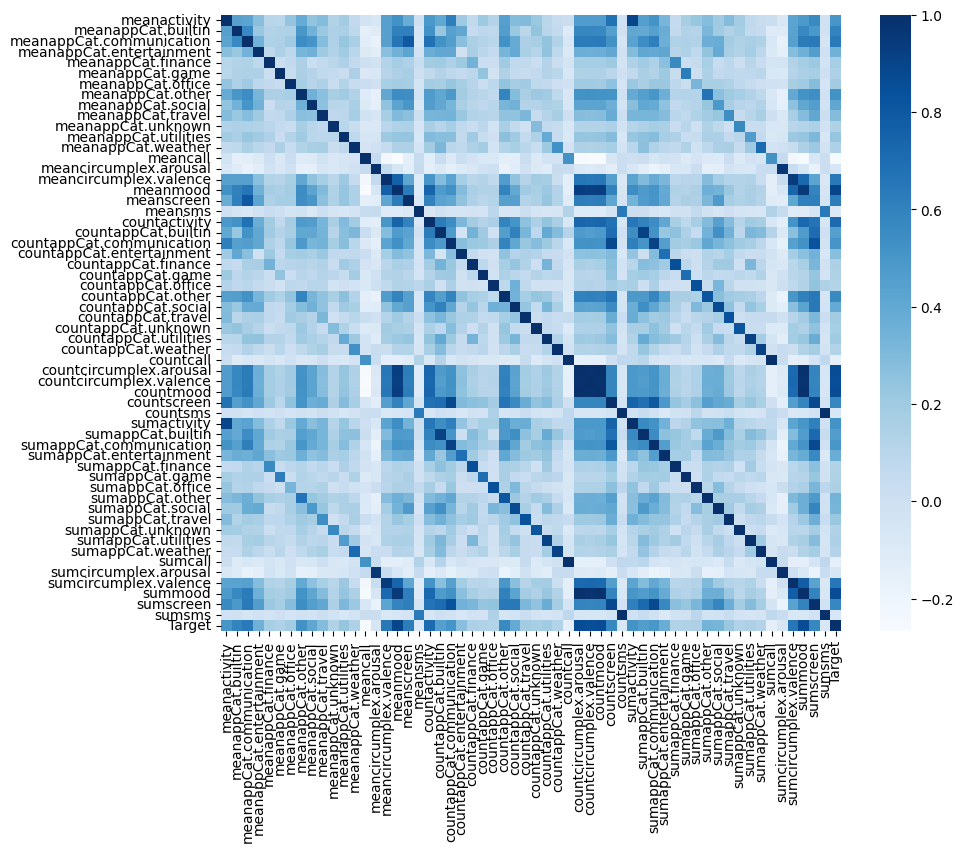

In [342]:
import seaborn as sb
import matplotlib.pyplot as plt

corr = df_pivoted.corr()

plt.figure(figsize=(10, 8))
sb.heatmap(corr, cmap="Blues",yticklabels=True, xticklabels = True)

corr_abs = corr['Target'].abs()
sorted_corr = corr_abs.sort_values()

selected_features = sorted_corr.keys()[-9:-4]

print(selected_features)


In [343]:
# Ensure target_date is in datetime format
df_pivoted['date'] = pd.to_datetime(df_pivoted['date'])

# Setting the index to target_date for rolling computation
df_pivoted.set_index('date', inplace=True)

# Applying rolling mean to all features
for feature in selected_features:
    df_pivoted[f'time_window_{feature}'] = df_pivoted.groupby('id')[feature].transform(lambda x: x.rolling(time_window, closed='right').mean())

df_pivoted.reset_index(inplace=True)

In [344]:
# Displaying df_pivoted
df_pivoted

,date,id,meanactivity,meanappCat.builtin,meanappCat.communication,meanappCat.entertainment,meanappCat.finance,meanappCat.game,meanappCat.office,meanappCat.other,...,summood,sumscreen,sumsms,Target,Target_date,time_window_meancircumplex.valence,time_window_sumcircumplex.valence,time_window_countactivity,time_window_countcircumplex.valence,time_window_countcircumplex.arousal
0,2014-02-17,AS14.01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.000000,...,0.0,0.000000,0.0,0.0,2014-02-18,0.0,0.0,0.0,0.0,0.0
1,2014-02-18,AS14.01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.000000,...,0.0,0.000000,0.0,0.0,2014-02-19,0.0,0.0,0.0,0.0,0.0
2,2014-02-19,AS14.01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.000000,...,0.0,0.000000,2.0,0.0,2014-02-20,0.0,0.0,0.0,0.0,0.0
3,2014-02-20,AS14.01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.000000,...,0.0,0.000000,3.0,0.0,2014-02-21,0.0,0.0,0.0,0.0,0.0
4,2014-02-21,AS14.01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.000000,...,0.0,0.000000,1.0,0.0,2014-02-22,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941,2014-05-26,AS14.33,0.115201,7.711316,34.320472,68.876900,0.0,0.0,130.530,16.845500,...,27.0,7193.945999,3.0,6.2,2014-05-27,0.0,0.0,13.0,5.0,5.0
1942,2014-05-27,AS14.33,0.012704,5.004143,59.382943,62.347000,0.0,0.0,0.000,17.835750,...,31.0,4089.879001,2.0,8.2,2014-05-28,0.4,2.0,24.0,5.0,5.0
1943,2014-05-28,AS14.33,0.103301,7.718042,37.238750,43.907571,0.0,0.0,21.254,27.891895,...,41.0,7551.971998,1.0,7.0,2014-05-29,1.2,6.0,24.0,5.0,5.0
1944,2014-05-29,AS14.33,0.169354,6.452161,54.388125,68.369000,0.0,0.0,0.000,9.734000,...,21.0,560.093000,1.0,6.8,2014-05-30,1.0,3.0,24.0,3.0,3.0


In [345]:
# Normalize and exclude by column name and data type
def normalize_numeric(x):
    if x.name not in ['Target', 'date'] and x.dtype in ['int64', 'float64']:
        return (x - x.min()) / (x.max() - x.min())
    else:
        return x

# Apply the function to all columns with selective exclusions
normalized_df = df_pivoted.apply(normalize_numeric)
normalized_df

,date,id,meanactivity,meanappCat.builtin,meanappCat.communication,meanappCat.entertainment,meanappCat.finance,meanappCat.game,meanappCat.office,meanappCat.other,...,summood,sumscreen,sumsms,Target,Target_date,time_window_meancircumplex.valence,time_window_sumcircumplex.valence,time_window_countactivity,time_window_countcircumplex.valence,time_window_countcircumplex.arousal
0,2014-02-17,AS14.01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,2014-02-18,0.384615,0.357143,0.000000,0.000000,0.000000
1,2014-02-18,AS14.01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,2014-02-19,0.384615,0.357143,0.000000,0.000000,0.000000
2,2014-02-19,AS14.01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.117647,0.0,2014-02-20,0.384615,0.357143,0.000000,0.000000,0.000000
3,2014-02-20,AS14.01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.176471,0.0,2014-02-21,0.384615,0.357143,0.000000,0.000000,0.000000
4,2014-02-21,AS14.01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.058824,0.0,2014-02-22,0.384615,0.357143,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941,2014-05-26,AS14.33,0.203475,0.129265,0.182791,0.157518,0.0,0.0,0.876923,0.097640,...,0.551020,0.466976,0.176471,6.2,2014-05-27,0.384615,0.357143,0.541667,0.833333,0.833333
1942,2014-05-27,AS14.33,0.022439,0.083885,0.316275,0.142584,0.0,0.0,0.000000,0.103379,...,0.632653,0.265483,0.117647,8.2,2014-05-28,0.507692,0.500000,1.000000,0.833333,0.833333
1943,2014-05-28,AS14.33,0.182456,0.129378,0.198334,0.100414,0.0,0.0,0.142788,0.161667,...,0.836735,0.490216,0.058824,7.0,2014-05-29,0.753846,0.785714,1.000000,0.833333,0.833333
1944,2014-05-29,AS14.33,0.299123,0.108158,0.289672,0.156356,0.0,0.0,0.000000,0.056420,...,0.428571,0.036357,0.058824,6.8,2014-05-30,0.692308,0.571429,1.000000,0.500000,0.500000


In [346]:
# After normalizing drop target and  fill in missing values
normalized_df.dropna(subset='Target', inplace=True)
normalized_df.fillna(0, inplace=True)
normalized_df

,date,id,meanactivity,meanappCat.builtin,meanappCat.communication,meanappCat.entertainment,meanappCat.finance,meanappCat.game,meanappCat.office,meanappCat.other,...,summood,sumscreen,sumsms,Target,Target_date,time_window_meancircumplex.valence,time_window_sumcircumplex.valence,time_window_countactivity,time_window_countcircumplex.valence,time_window_countcircumplex.arousal
0,2014-02-17,AS14.01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,2014-02-18,0.384615,0.357143,0.000000,0.000000,0.000000
1,2014-02-18,AS14.01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,2014-02-19,0.384615,0.357143,0.000000,0.000000,0.000000
2,2014-02-19,AS14.01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.117647,0.0,2014-02-20,0.384615,0.357143,0.000000,0.000000,0.000000
3,2014-02-20,AS14.01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.176471,0.0,2014-02-21,0.384615,0.357143,0.000000,0.000000,0.000000
4,2014-02-21,AS14.01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.058824,0.0,2014-02-22,0.384615,0.357143,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941,2014-05-26,AS14.33,0.203475,0.129265,0.182791,0.157518,0.0,0.0,0.876923,0.097640,...,0.551020,0.466976,0.176471,6.2,2014-05-27,0.384615,0.357143,0.541667,0.833333,0.833333
1942,2014-05-27,AS14.33,0.022439,0.083885,0.316275,0.142584,0.0,0.0,0.000000,0.103379,...,0.632653,0.265483,0.117647,8.2,2014-05-28,0.507692,0.500000,1.000000,0.833333,0.833333
1943,2014-05-28,AS14.33,0.182456,0.129378,0.198334,0.100414,0.0,0.0,0.142788,0.161667,...,0.836735,0.490216,0.058824,7.0,2014-05-29,0.753846,0.785714,1.000000,0.833333,0.833333
1944,2014-05-29,AS14.33,0.299123,0.108158,0.289672,0.156356,0.0,0.0,0.000000,0.056420,...,0.428571,0.036357,0.058824,6.8,2014-05-30,0.692308,0.571429,1.000000,0.500000,0.500000


In [347]:
# Calculate the difference
normalized_df['date_difference'] = (normalized_df['Target_date'] - normalized_df['date']).dt.days
 
# Keep rows that predict next day
normalized_df = normalized_df[normalized_df['date_difference'] == 1]

normalized_df.drop(columns='date_difference', inplace=True)

C:\Users\tomsl\AppData\Local\Temp\ipykernel_21732\2244113363.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_df.drop(columns='date_difference', inplace=True)


In [348]:
### Binning target ###

# Calculate the size of each bin
bins_size = len(df_pivoted['Target']) / 4

# Ensure integer count for indexing (rounding up if not a whole number)
bins_size = int(np.ceil(bins_size))

# Sort DataFrame by 'target'
normalized_df.sort_values(by='Target', inplace=True)

# Create a new column 'bin' that assigns each row to a bin
normalized_df['bin'] = np.floor(np.arange(len(normalized_df)) / bins_size)

# Optionally, you might want to adjust if the last bin has too few items due to rounding
max_bin = normalized_df['bin'].max()
if len(normalized_df[normalized_df['bin'] == max_bin]) < bins_size * 0.5:  # Arbitrary threshold of 50% of bin size
    normalized_df['bin'] = np.floor(np.arange(len(normalized_df)) / (bins_size - 1))

C:\Users\tomsl\AppData\Local\Temp\ipykernel_21732\1165429632.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_df.sort_values(by='Target', inplace=True)
C:\Users\tomsl\AppData\Local\Temp\ipykernel_21732\1165429632.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_df['bin'] = np.floor(np.arange(len(normalized_df)) / bins_size)


In [349]:
# Calculate min and max for each bin
bin_stats = normalized_df.groupby('bin')['Target'].agg(['min', 'max'])
print(bin_stats)

     min       max
bin               
0.0  0.0  0.000000
1.0  0.0  6.800000
2.0  6.8  7.400000
3.0  7.4  9.333333


In [350]:
# Applying bins using the corrected lambda function
normalized_df['handmatige_bin'] = normalized_df['Target'].apply(
    lambda x: 0 if x < 6.4 else (1 if x >= 6.4 and x < 7.6 else 2)
)

C:\Users\tomsl\AppData\Local\Temp\ipykernel_21732\1223088566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_df['handmatige_bin'] = normalized_df['Target'].apply(


In [351]:
normalized_df.columns

Index(['date', 'id', 'meanactivity', 'meanappCat.builtin',
       'meanappCat.communication', 'meanappCat.entertainment',
       'meanappCat.finance', 'meanappCat.game', 'meanappCat.office',
       'meanappCat.other', 'meanappCat.social', 'meanappCat.travel',
       'meanappCat.unknown', 'meanappCat.utilities', 'meanappCat.weather',
       'meancall', 'meancircumplex.arousal', 'meancircumplex.valence',
       'meanmood', 'meanscreen', 'meansms', 'countactivity',
       'countappCat.builtin', 'countappCat.communication',
       'countappCat.entertainment', 'countappCat.finance', 'countappCat.game',
       'countappCat.office', 'countappCat.other', 'countappCat.social',
       'countappCat.travel', 'countappCat.unknown', 'countappCat.utilities',
       'countappCat.weather', 'countcall', 'countcircumplex.arousal',
       'countcircumplex.valence', 'countmood', 'countscreen', 'countsms',
       'sumactivity', 'sumappCat.builtin', 'sumappCat.communication',
       'sumappCat.entertainment'

In [352]:
normalized_df = normalized_df.drop(columns=['meanactivity', 'meanappCat.builtin',
       'meanappCat.communication', 'meanappCat.entertainment','Target',
       'Target_date',
       'meanappCat.finance', 'meanappCat.game', 'meanappCat.office',
       'meanappCat.other', 'meanappCat.social', 'meanappCat.travel',
       'meanappCat.unknown', 'meanappCat.utilities', 'meanappCat.weather',
       'meancall','meanmood', 'meanscreen', 'meansms','sumcircumplex.arousal',
       'sumcircumplex.valence','summood', 'countmood','countactivity'], axis=1)

In [353]:
normalized_df.columns

Index(['date', 'id', 'meancircumplex.arousal', 'meancircumplex.valence',
       'countappCat.builtin', 'countappCat.communication',
       'countappCat.entertainment', 'countappCat.finance', 'countappCat.game',
       'countappCat.office', 'countappCat.other', 'countappCat.social',
       'countappCat.travel', 'countappCat.unknown', 'countappCat.utilities',
       'countappCat.weather', 'countcall', 'countcircumplex.arousal',
       'countcircumplex.valence', 'countscreen', 'countsms', 'sumactivity',
       'sumappCat.builtin', 'sumappCat.communication',
       'sumappCat.entertainment', 'sumappCat.finance', 'sumappCat.game',
       'sumappCat.office', 'sumappCat.other', 'sumappCat.social',
       'sumappCat.travel', 'sumappCat.unknown', 'sumappCat.utilities',
       'sumappCat.weather', 'sumcall', 'sumscreen', 'sumsms',
       'time_window_meancircumplex.valence',
       'time_window_sumcircumplex.valence', 'time_window_countactivity',
       'time_window_countcircumplex.valence',
   

In [354]:
normalized_df.to_csv(f'dataset_{days_in_past}.csv')